# Подбор модели с использованием AutoML

Подбор пайплайнов с помощью AutoML пакета [GAMA](https://openml-labs.github.io/gama/master)  
В качестве данных был выбран "широкий вариант" датасета **data_for_model.xlsx**

Тестировались разные базовые методы поиска оптимального пайплайна, включенные в GAMA:

- _Asynchronous Evolutionary Algorithm_: (генетический поиск) Evolve a population of machine learning pipelines, drawing new machine learning pipelines from the best of the population.

- _Asynchronous Successive Halving Algorithm_: A bandit-based approach where many machine learning pipelines iteratively get evaluated and eliminated on bigger fractions of the data. 


Разные тесты проводились с разным лимитом времени. от 3 мин до 3 часов


In [1]:
%reload_ext autoreload
%autoreload 2

from _shared import *

NOTEBOOK_ID = '2'

In [2]:
import datetime as dt
import json
import logging

import pandas as pd

from gama import GamaRegressor
from gama.search_methods import AsynchronousSuccessiveHalving

from sklearn.model_selection import train_test_split

import uai.data
import uai.models

In [3]:
# Загрузка исходных данных для модели

df = pd.read_csv(ROOT_PATH / 'data/processed/data_for_model_1.csv')
df.head(3)

,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13.0,3.32,1,...,0,0,0,0,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15.0,2.01,2,...,0,0,0,0,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26.0,2.75,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['id'] = df['id'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     1456 non-null   category
 1   age                    1456 non-null   int64   
 2   dose                   1456 non-null   float64 
 3   prev_INR(MHO)          1456 non-null   float64 
 4   atrial_fibrillation    1456 non-null   int64   
 5   mitral_valve           1456 non-null   int64   
 6   aortal_valve           1456 non-null   int64   
 7   date_diff              1456 non-null   float64 
 8   INR(MHO)               1456 non-null   float64 
 9   sample                 1456 non-null   int64   
 10  pass_dose              1456 non-null   int64   
 11  age_level              1456 non-null   int64   
 12  age_level1             1456 non-null   int64   
 13  age_level2             1456 non-null   int64   
 14  age_level3             1456 non-null   i

In [5]:
def select_pipe(
        train_df,
        *,
        search=None,
        max_total_time=3600,
        scoring=('neg_mean_squared_error', 'r2'),
        random_state=RANDOM_SEED,
        regularize_length=True,
        preset='simple',
        n_jobs=1,
        verbose=logging.WARNING,
    ):
    """
    Находим лучшую модель-регрессор для заданного набора данных.
    """
    X_train, y_train = uai.data.to_X_y(train_df)

    gama = GamaRegressor(
        search=search,
        max_total_time=max_total_time, 
        scoring=scoring,                      
        random_state=random_state, 
        regularize_length=regularize_length,
        # store="logs",
        preset=preset,
        n_jobs=n_jobs,
        verbosity=verbose
    )
    
    delta = max_total_time / 60
    t0 = dt.datetime.now()
    eta = t0 + dt.timedelta(seconds=max_total_time)
    def to_str(t):
        return t.strftime('%Y-%m-%d %H:%M')

    print(f'{to_str(t0)} Подбор модели завершится приблизительно за {delta} мин, в {to_str(eta)}')
    gama.fit(X_train, y_train)
    t1 = dt.datetime.now()
    print(f'{to_str(t1)} Модель подобрана')
    # print(gama.score(X_test, y_test))

    return gama

## Подбор с AsynchronousSuccessiveHalving 

In [6]:
MAX_TIME = 60 * 60
N_JOBS = 8

# Без стратификации
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

gama = select_pipe(
    train_df,
    search=AsynchronousSuccessiveHalving(),
    max_total_time=MAX_TIME,
    n_jobs=N_JOBS,
)

2023-11-05 02:52 Подбор модели завершится приблизительно за 1.0 мин, в 2023-11-05 02:53
2023-11-05 02:53 Модель подобрана


Средняя абсолютная ошибка (MAE):                         0.46
Среднеквадратичная ошибка (MSE):                         0.68
Коэффициент детерминации (R^2):                          0.72
Средняя абсолютная процентная ошибка (MAPE):            19.50%
Доля предсказаний с отклонением не более 0,5 мг:        67.81%


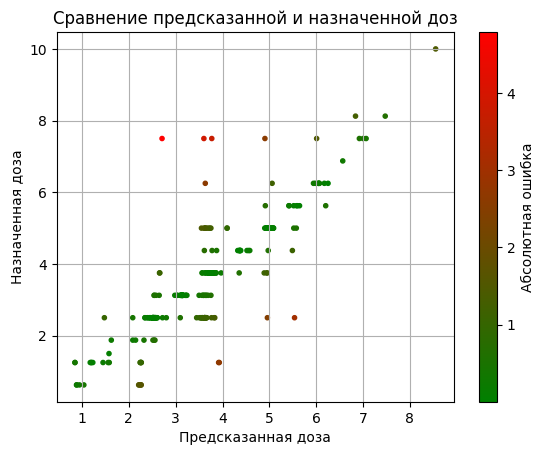

Подобранная модель сохранена в файл: ..\models\gama_ASH_60s.py
Описание обучения: ..\models\gama_ASH_60s.json


In [7]:
# Тестируем модель, сохраняем ее и описание качества работы в файлы

# Тестируем на тестовой выборке
X_test, y_test = uai.data.to_X_y(test_df)
y_pred = gama.predict(X_test)
scores = uai.models.calculate_metrics(y_pred, y_test)
uai.models.print_metrics(scores)

uai.models.plot_predictions(y_pred, y_test)

# Сохраняем модель в файл
model_name = f'gama_ASH_{MAX_TIME}s'
file_py = (ROOT_PATH / 'models' / model_name).with_suffix('.py')
gama.export_script(file_py)
print(f'Подобранная модель сохранена в файл: {file_py}')

# Сохраняем описание обучения в файл
spec = {
    'model': model_name,
    'max_total_time': MAX_TIME,
    'test': scores,
}

file_json = file_py.with_suffix('.json')
with file_json.open('w') as f:
    json.dump(spec, f, indent=4)

print(f'Описание обучения: {file_json}')

In [8]:
# Если ничего не напечаталось - то не дошли сюда, и где-то в ноутбуке ошибка
import datetime as dt
print('Ноутбук завершен:', dt.datetime.now())

Ноутбук завершен: 2023-11-05 02:53:02.646707
